In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df_k5000 = pd.read_csv('../data/dataset/5.df_k5000_clustering.csv', index_col=0)
df_k5100 = pd.read_csv('../data/dataset/5.df_k5100_clustering.csv', index_col=0)
df_k5200 = pd.read_csv('../data/dataset/5.df_k5200_clustering.csv', index_col=0)
df_k5300 = pd.read_csv('../data/dataset/5.df_k5300_clustering.csv', index_col=0)
df_k5400 = pd.read_csv('../data/dataset/5.df_k5400_clustering.csv', index_col=0)
df_k5500 = pd.read_csv('../data/dataset/5.df_k5500_clustering.csv', index_col=0)
df_k5600 = pd.read_csv('../data/dataset/5.df_k5600_clustering.csv', index_col=0)
df_k5700 = pd.read_csv('../data/dataset/5.df_k5700_clustering.csv', index_col=0)
df_k5800 = pd.read_csv('../data/dataset/5.df_k5800_clustering.csv', index_col=0)
df_k5900 = pd.read_csv('../data/dataset/5.df_k5900_clustering.csv', index_col=0)

In [9]:
def concat_frames(frames):
  for i in range(len(frames)):
    f = frames[i]
    f['cluster'] = f['cluster'].astype('int') + 1000*i
    frames[i] = f
    
  pd.concat(frames, axis=0)

In [10]:
candidates_full_cols = pd.concat([df_k5000, df_k5100, df_k5200, df_k5300, df_k5400,
                                  df_k5500, df_k5600, df_k5700, df_k5800, df_k5900], axis=0)

### TODO
-  groupby, sum
- 데이터 형식 바꾸기. cluster: subset, cell_id: element, count_cust: cost

In [11]:
candidates = candidates_full_cols.copy().groupby(['cluster', 'cell_id']).sum().reset_index()

In [12]:
candidates = candidates.copy()[['cluster', 'cell_id', 'count_cust']]

In [13]:
from collections import defaultdict

universe = set([])
subsets = defaultdict(set)
demands = defaultdict(int)

for _, r in candidates.iterrows():
  cluster, cell_id, count_cust = r
  
  cell_id = str(int(cell_id))
  cluster = str(int(cluster))
  universe.add(cell_id)
  subsets[cluster].add(cell_id)
  demands[cell_id] = count_cust

In [14]:
def greedy_set_cover(universe, subsets, costs):
    elements = set(e for s in subsets.keys() for e in subsets[s])
    # elements don't cover universe -> invalid input for set cover
    if elements != universe:
        return None

    # track elements of universe covered
    covered = set()
    cover_sets = []

    while covered != universe:
        min_cost_elem_ratio = float("inf")
        min_set = None
        # find set with minimum cost:elements_added ratio
        for s, elements in subsets.items():
            new_elements = len(elements - covered)
            # set may have same elements as already covered -> new_elements = 0
            # check to avoid division by 0 error
            if new_elements != 0:
                cost_elem_ratio = costs[s] / new_elements
                if cost_elem_ratio < min_cost_elem_ratio:
                    min_cost_elem_ratio = cost_elem_ratio
                    min_set = s
        cover_sets.append(min_set)
        # union
        covered |= subsets[min_set]
    return cover_sets

In [15]:
def calculate_subset_demand(subsets, demands):
      total_demands = {}
      for subset, elements in subsets.items():
        cost = 0
        for e in elements:
          cost += demands[str(e)]
        
        total_demands[subset] = cost
        
      total_demands_recip = {}
      
      for k, v in total_demands.items():
        total_demands_recip[k] = 1/v
        
      return [total_demands, total_demands_recip]

In [16]:
total_demands, total_demands_recip = calculate_subset_demand(subsets, demands)

In [17]:
cover = greedy_set_cover(universe, subsets, total_demands_recip)

In [18]:
len(cover)

1223

In [19]:
cover_df = pd.DataFrame(cover)
cover_df.columns = ['cluster']
candidates_full_cols['cluster'] = candidates_full_cols['cluster'].astype('str')

In [20]:
clusters_df = pd.merge(cover_df, candidates_full_cols, how='left', on='cluster')
clusters_df

,cluster,cell_id,resident_table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,2276,85159066,0,20220628,2,4146,용인시,41463520,구갈동,127.11791,37.273125,FEMALE,12,EV라운지,4,4.006
1,2276,85191065,0,20220627,1,4146,용인시,41463520,구갈동,127.11903,37.273580,MALE,8,하이차저,5,3.048
2,2276,85191065,0,20220618,6,4146,용인시,41463520,구갈동,127.11903,37.273580,MALE,9,EV라운지,1,3.048
3,2276,85191065,0,20220604,6,4146,용인시,41463520,구갈동,127.11903,37.273580,MALE,13,EV라운지,6,3.670
4,2276,85191065,0,20220630,4,4146,용인시,41463520,구갈동,127.11903,37.273580,MALE,13,EV라운지,3,3.670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582334,4465,87014857,1,20220629,3,4146,용인시,41461520,역삼동,127.18350,37.231403,FEMALE,12,EV라운지,5,4.025
1582335,4465,87014857,1,20220619,7,4146,용인시,41461520,역삼동,127.18350,37.231403,MALE,10,EV라운지,1,4.138
1582336,4465,87014857,1,20220630,4,4146,용인시,41461520,역삼동,127.18350,37.231403,MALE,3,G차저,2,3.963
1582337,4465,87014857,1,20220620,1,4146,용인시,41461520,역삼동,127.18350,37.231403,MALE,10,EV라운지,3,4.138


### Coverage

- 수요가 발생한 노드의 수: `len(df_k1000['cell_id'].unique())` = 18547
- 커버 가능한 노드의 수: `len(clusters_df['cell_id'].unique())` = 17976

커버리지 = 수요노드 / 커버노드 = 17976 / 18547 = 96.92%


In [22]:
demand_count = len(clusters_df['cell_id'].unique())
covered_count = len(df_k5000['cell_id'].unique())
print(covered_count) #커버 가능한 노드의 수
print(demand_count) #수요가 발생한 노드의 수

print(demand_count / covered_count * 100)


18547
18547
100.0


## Cluster의 중심 좌표 구하기

In [23]:
# cluster로 그룹화 후 개별 데이터프레임으로 쪼개기

grouped_clusters_df = clusters_df.groupby('cluster')
groups = [grouped_clusters_df.get_group(g).reset_index() for g in grouped_clusters_df.groups]

In [24]:
groups[1].head()

,index,cluster,cell_id,resident_table,base_dt,dow,ccw_cd,ccw_nm,adng_cd,adng_nm,cell_xcrd,cell_ycrd,gender,age,app_web,time_zone,count_cust
0,831908,1009,85255018,0,20220621,2,4146,용인시,41463535,보라동,127.121390,37.254208,FEMALE,11,EV라운지,6,3.227
1,831909,1009,85271015,0,20220614,2,4146,용인시,41463535,보라동,127.121956,37.253307,FEMALE,7,하이차저,4,3.632
2,831910,1009,85271015,0,20220603,5,4146,용인시,41463535,보라동,127.121956,37.253307,MALE,3,G차저,4,4.535
3,831911,1009,85271015,0,20220613,1,4146,용인시,41463535,보라동,127.121956,37.253307,FEMALE,7,하이차저,3,3.632
4,831912,1009,85271015,0,20220620,1,4146,용인시,41463535,보라동,127.121956,37.253307,MALE,3,G차저,4,4.535


In [42]:
xcrds = []
ycrds = []

for g in groups:
  min_x, max_x, min_y, max_y = g['cell_xcrd'][0], g['cell_xcrd'][0], g['cell_ycrd'][0], g['cell_ycrd'][0]
  
  for i, r in g.iterrows():
    min_x = min(min_x, r['cell_xcrd'])
    max_x = max(max_x, r['cell_xcrd'])
    min_y = min(min_y, r['cell_ycrd'])
    max_y = max(max_y, r['cell_ycrd'])
    
  xcrds.append((min_x + max_x) / 2)
  ycrds.append((min_y + max_y) / 2)

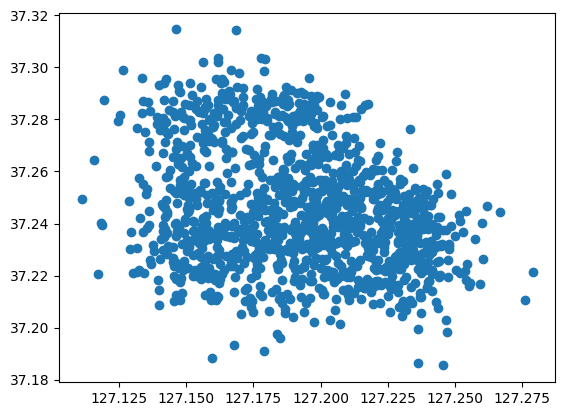

In [43]:
import matplotlib.pyplot as plt

plt.scatter(xcrds, ycrds)
plt.show()